<a href="https://colab.research.google.com/github/Sagor0078/Deep-Learning/blob/main/catAndDogClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

#check our work directory
import os

#to unzip datasets
import zipfile

In [ ]:
lr = 0.001 # learning_rate
batch_size = 100 # we will use mini-batch method
epochs = 10 # How much to train a model

In [ ]:
os.listdir('/content/drive/MyDrive/imageClassifierPytorch')

['sample_submission.csv', 'test.zip', 'train.zip']

In [ ]:
os.makedirs('../data', exist_ok=True)

In [ ]:
base_dir = '/content/drive/MyDrive/imageClassifierPytorch'
train_dir = '../data/train'
test_dir = '../data/test'

In [ ]:
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('../data')

with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('../data')

In [ ]:
os.listdir(train_dir)[:5]

['dog.2119.jpg',
 'dog.4651.jpg',
 'cat.4999.jpg',
 'dog.5655.jpg',
 'cat.12192.jpg']

In [ ]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [ ]:
len(train_list)

25000

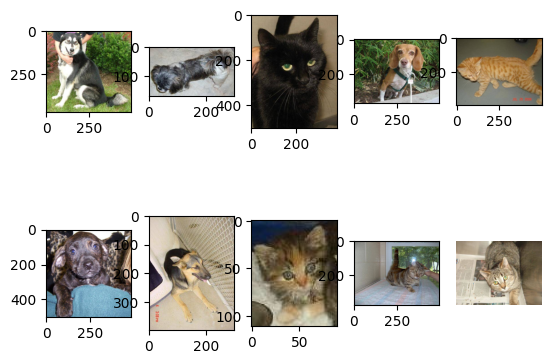

In [ ]:
from PIL import Image
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [ ]:
train_list[0].split('/')[-1].split('.')[0]

'dog'

In [ ]:
int(test_list[0].split('/')[-1].split('.')[0])

11182

In [ ]:
print(len(train_list), len(test_list))

25000 12500


In [ ]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [ ]:
#data augmentation
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [ ]:
#load dataset
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform


    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0

        return img_transformed,label

In [ ]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [ ]:
print(len(train_data), len(train_loader))

20000 200


In [ ]:
print(len(val_data), len(val_loader))

5000 50


In [ ]:
train_data[0][0].shape # **

torch.Size([3, 224, 224])

In [ ]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Cnn()
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [ ]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in train_loader:
        data = data
        label = label

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)

    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))


    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data
            label = label

            val_output = model(data)
            val_loss = criterion(val_output,label)


            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)

        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.6502498388290405, train loss : 0.6189762353897095
Epoch : 1, val_accuracy : 0.6881999969482422, val_loss : 0.5948361158370972
Epoch : 2, train accuracy : 0.7082002758979797, train loss : 0.5608701705932617
Epoch : 2, val_accuracy : 0.7063998579978943, val_loss : 0.5596461296081543
Epoch : 3, train accuracy : 0.7290000319480896, train loss : 0.534856915473938
Epoch : 3, val_accuracy : 0.728600025177002, val_loss : 0.536438524723053
Epoch : 4, train accuracy : 0.7425503730773926, train loss : 0.5146977305412292
Epoch : 4, val_accuracy : 0.7331997752189636, val_loss : 0.5322703719139099
Epoch : 5, train accuracy : 0.7559001445770264, train loss : 0.49716827273368835
Epoch : 5, val_accuracy : 0.7558000087738037, val_loss : 0.49326077103614807
Epoch : 6, train accuracy : 0.7598999738693237, train loss : 0.4879615604877472
Epoch : 6, val_accuracy : 0.7627999186515808, val_loss : 0.48681318759918213
Epoch : 7, train accuracy : 0.7678000926971436, train loss : 0.4

In [ ]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))

In [ ]:
dog_probs.sort(key = lambda x : int(x[0]))
print(dog_probs)

[('1', 0.719977855682373), ('2', 0.9517236948013306), ('3', 0.7721859216690063), ('4', 0.9835989475250244), ('5', 0.11431992799043655), ('6', 0.7389900088310242), ('7', 0.7300660610198975), ('8', 0.1707630753517151), ('9', 0.16969817876815796), ('10', 0.16131162643432617), ('11', 0.10446646064519882), ('12', 0.9585034251213074), ('13', 0.12497835606336594), ('14', 0.6871530413627625), ('15', 0.21447087824344635), ('16', 0.1940312534570694), ('17', 0.9243023991584778), ('18', 0.9687957763671875), ('19', 0.3412264585494995), ('20', 0.06913285702466965), ('21', 0.32148346304893494), ('22', 0.3518577218055725), ('23', 0.7985358834266663), ('24', 0.518082857131958), ('25', 0.6406288743019104), ('26', 0.6104364991188049), ('27', 0.891497015953064), ('28', 0.05333932861685753), ('29', 0.8822994828224182), ('30', 0.9465481638908386), ('31', 0.7692111730575562), ('32', 0.08779845386743546), ('33', 0.976527988910675), ('34', 0.41467127203941345), ('35', 0.05544709414243698), ('36', 0.16561135649

In [ ]:
idx = list(map(lambda x: x[0],dog_probs))
prob = list(map(lambda x: x[1],dog_probs))

In [ ]:
submission = pd.DataFrame({'id':idx,'label':prob})

In [ ]:
submission

,id,label
0,1,0.719978
1,2,0.951724
2,3,0.772186
3,4,0.983599
4,5,0.114320
...,...,...
12495,12496,0.077247
12496,12497,0.327442
12497,12498,0.282466
12498,12499,0.829388


In [ ]:
submission.to_csv('result.csv',index=False)

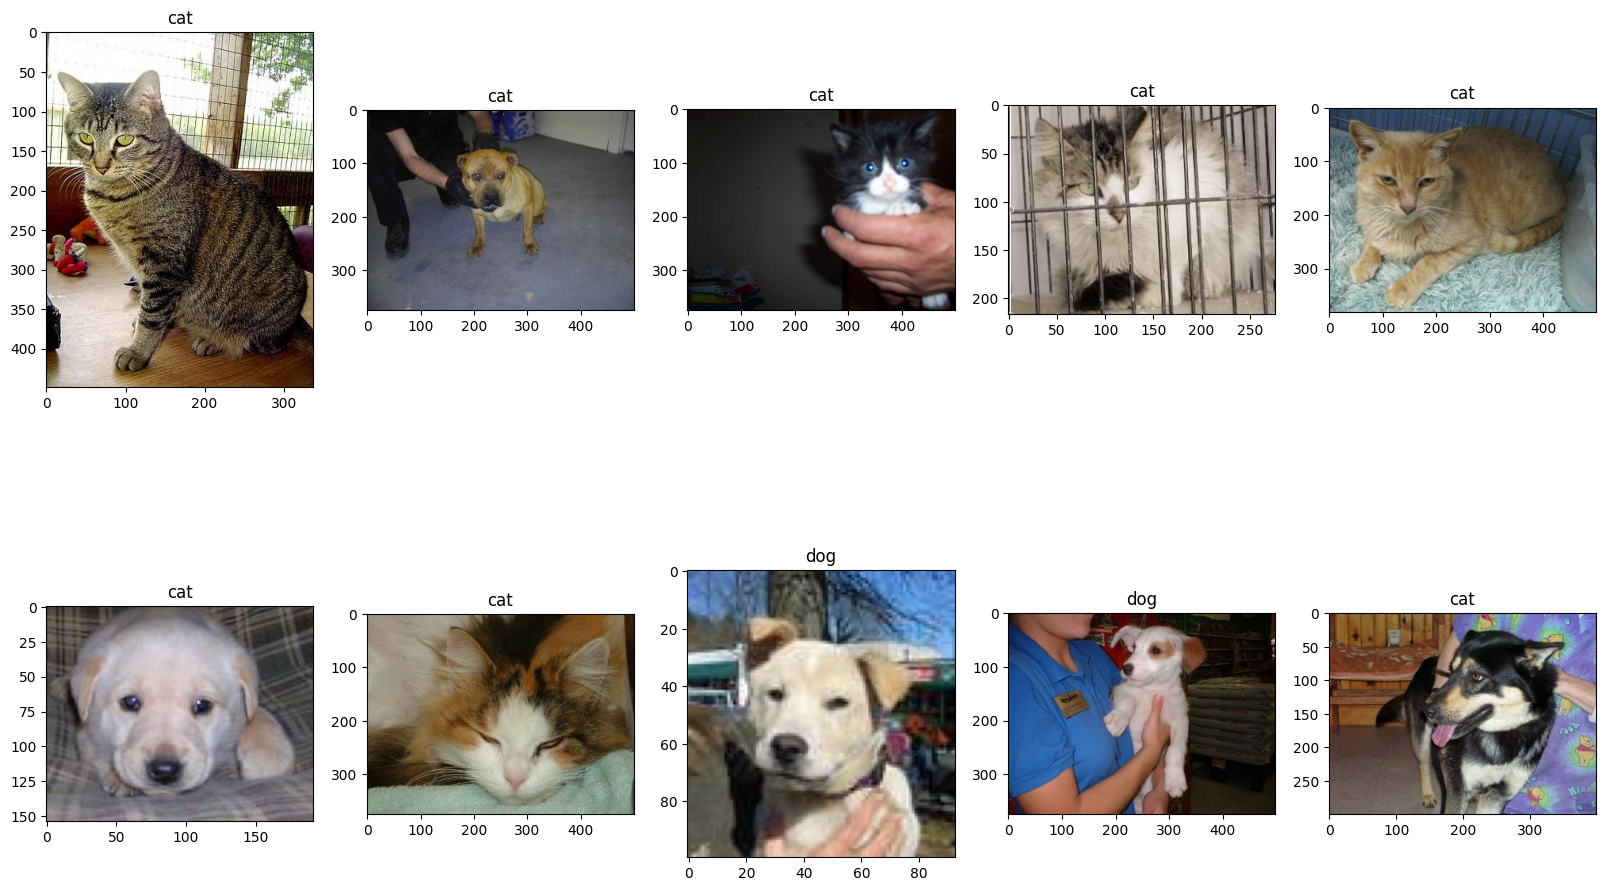

In [ ]:
import random

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():

    i = random.choice(submission['id'].values)

    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0

    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)

    ax.set_title(class_[label])
    ax.imshow(img)